In [2]:
# import packages
import os 
import shutil
from matplotlib import pyplot as plt 
import yaml
import random
import math
import pandas as pd
import cv2
%matplotlib inline

In [3]:
# function to get num of class from txt files
def get_cls_label(file_path):
    cls = []
    with open(file_path, 'r')as f:
        contents = f.readlines()
        for content in contents:
            c = content.strip().split()
            cls.append(int(c[0]))
        return cls
    
# train test valid split function 80, 10, 10 by default
def train_test_valid_split(data: list, test_size = 0.1, valid_size = 0.1):
    random.shuffle(data)

    total_size = len(data)
    test_split = math.ceil(total_size * test_size)
    valid_split = math.ceil(total_size * valid_size)

    test_data = data[:test_split]
    valid_data = data[test_split:valid_split+test_split]
    train_data = data[valid_split+test_split:]

    return train_data, test_data, valid_data

# create a structure for yolo dataset function
def create_yolov5_folder_data(base_path, dataset_name):

    dname = os.path.join(base_path, dataset_name)
    os.makedirs(dname, exist_ok=True)

    subf = [os.path.join(dname, 'train'), os.path.join(dname, 'test'), os.path.join(dname, 'valid')]
    
    for sub in subf:
        os.makedirs(sub, exist_ok=True)
        os.makedirs(os.path.join(sub, 'images'), exist_ok=True)
        os.makedirs(os.path.join(sub, 'labels'), exist_ok=True)
        print(sub)

# replace txt file with the .jpg 
def conv_txt_jpg(txt_file):
    name = os.path.splitext(txt_file)[0] + '.jpg'

    return name


In [4]:
# origin datasets (consider that the data has not split into train valid and test yet)
dataset = "/home/nattkorat/Desktop/klpr_dataset/places_db"

train_dir = os.path.join(dataset, 'train')
yalm_file = os.path.join(dataset, 'data.yaml')

# get label from data
label_dir = os.path.join(train_dir, "labels")

files = os.listdir(label_dir)


# create file structure
database_name = 'v2_place_dataset'
target_dir = './'
create_yolov5_folder_data(target_dir, database_name)


# read yaml file
with open(os.path.join(yalm_file), 'r') as f:
    data = yaml.safe_load(f)

# get the class name
cls = data['names']
data_cls = {}

# create dict of class and file name
for cl in cls:
    data_cls[cl] = []

for fi in files:
    path_name = os.path.join(label_dir, fi)
    cl = get_cls_label(path_name)

    for c in cl:
        data_cls[cls[c]].append(fi)
data_info = {
    'name': [],
    'train': [],
    'test': [],
    'valid': []
}
# splitting the data
for key, value in data_cls.items():
    tr, ts, vl = train_test_valid_split(value)
    # print(key, 'train:', len(tr), 'test:', len(ts), 'valid:', len(vl))
    data_info['name'].append(key)
    data_info['train'].append(len(tr))
    data_info['test'].append(len(ts))
    data_info['valid'].append(len(vl))

    # we can now just copy image and label to the new folder
    # train
    for data in tr:
        # labels
        shutil.copyfile(os.path.join(train_dir, 'labels', data), os.path.join(target_dir, database_name, 'train/labels', data))
  
        # image
        shutil.copyfile(os.path.join(train_dir, 'images', conv_txt_jpg(data)), os.path.join(target_dir, database_name, 'train/images', conv_txt_jpg(data)))

    # testing
    for data in ts:
        # labels
        shutil.copyfile(os.path.join(train_dir, 'labels', data), os.path.join(target_dir, database_name, 'test/labels', data))
  
        # image
        shutil.copyfile(os.path.join(train_dir, 'images', conv_txt_jpg(data)), os.path.join(target_dir, database_name, 'test/images', conv_txt_jpg(data)))
    
    # valid
    for data in vl:
        # labels
        shutil.copyfile(os.path.join(train_dir, 'labels', data), os.path.join(target_dir, database_name, 'valid/labels', data))
  
        # image
        shutil.copyfile(os.path.join(train_dir, 'images', conv_txt_jpg(data)), os.path.join(target_dir, database_name, 'valid/images', conv_txt_jpg(data)))

data_info = pd.DataFrame(data_info)
data_info

./v2_place_dataset/train
./v2_place_dataset/test
./v2_place_dataset/valid


,name,train,test,valid
0,Banteay_Meanchey,134,17,17
1,Battambang,144,18,18
2,Cambodia,138,18,18
3,Kampong_Cham,165,21,21
4,Kampong_Chhnang,141,18,18
5,Kampong_Speu,127,16,16
6,Kampong_Thom,121,16,16
7,Kampot,135,18,18
8,Kandal,127,16,16
9,Kep,90,12,12


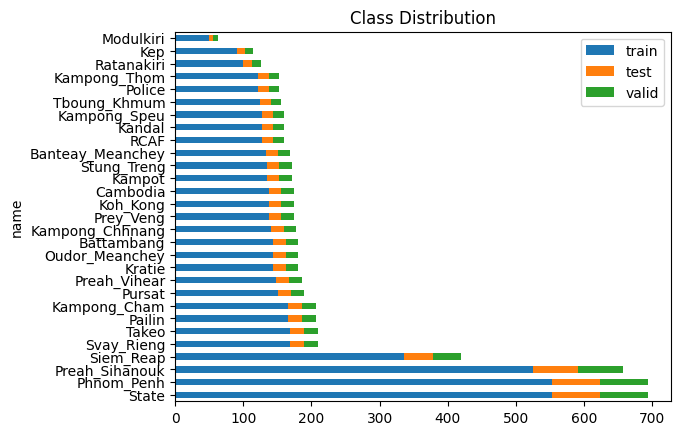

In [5]:
data_info = data_info.sort_values('train', axis=0, ascending= False)
data_info.plot(x='name', kind='barh', stacked=True, title='Class Distribution')
plt.show()

Text(0.5, 1.0, 'Data Distribution')

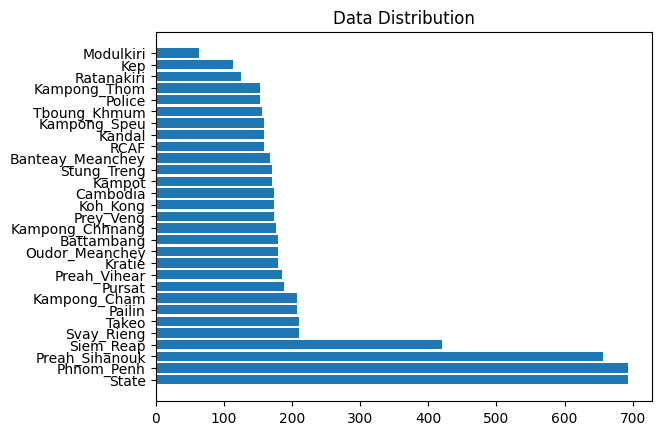

In [6]:
keys = list(data_cls.keys())
amount = [len(data_cls[i]) for i in keys]

df = {
    'place': keys,
    'amount': amount
}

df = pd.DataFrame(df)

df = df.sort_values('amount', axis=0, ascending= False)


plt.barh(df.place, df.amount)
plt.title("Data Distribution")

